In [2]:
import GEOparse
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns    
import scipy                                     


In [3]:
gse = GEOparse.get_GEO("GSE4271", destdir="data/",silent=True)

In [ ]:
expression_df = gse.pivot_samples('VALUE') # Some values in the thousands, apply log2 transformation
expression_df = np.log2(expression_df)

#conver expression data to csv
expression_df.T.to_csv("data/expression_data.csv")

expression_df = expression_df.T




meta = []
for gsm_name, gsm in gse.gsms.items():
    characteristics = gsm.metadata.get('characteristics_ch1', [])
    char_dict = {}
    for entry in characteristics:
        if ":" in entry:
            key, value = entry.split(":", 1)
            char_dict[key.strip()] = value.strip()   
    char_dict["sample"] = gsm_name
    char_dict["title"] = gsm.metadata.get("title", [""])[0]
    char_dict["source_name"] = gsm.metadata.get("source_name_ch1", [""])[0]
    meta.append(char_dict)
    
    
meta_df = pd.DataFrame(meta).set_index('sample')

meta_df.to_csv("data/metadata.csv")




sample
GSM96950      primary
GSM96951      primary
GSM96952      primary
GSM96953      primary
GSM96954      primary
              ...    
GSM97045      primary
GSM97046      primary
GSM97047      primary
GSM97048      primary
GSM97049    recurrent
Name: specimen type, Length: 100, dtype: object


In [101]:
id_in_mmc2 = meta_df["title"]
id_in_mmc2 = id_in_mmc2.dropna()
idlist = id_in_mmc2.tolist()
for id in idlist:
    id_in_mmc2 = id_in_mmc2.replace(id, id.split("PRB")[1])


mmc2dict = {}
for index in id_in_mmc2.index:
    id,types = id_in_mmc2[index].split(" ")
    if id not in mmc2dict:
        mmc2dict[id] = index
    else:
        mmc2dict[id] = mmc2dict[id] + "," + index

#convert values connected to mmc2 key to list
for id in mmc2dict:
    mmc2dict[id] = mmc2dict[id].split(",")

mmc2 = pd.read_excel("data/mmc2.xls", index_col=0)
subtype = mmc2["Subtype"].dropna().sort_index()


rows = []
for key, vals in mmc2dict.items():
    a = vals[0] if len(vals) > 0 else None
    b = vals[1] if len(vals) > 1 else None
    rows.append((key, a, b))

mmc2_df = pd.DataFrame(rows, columns=['id', 'A', 'B']).set_index('id')

mmc2_df.index = mmc2_df.index.astype(int)
subtype.index = subtype.index.astype(int)

# add Subtype column by reindexing / joining the subtype Series
mmc2_df['Subtype'] = subtype.reindex(mmc2_df.index)

who_col = next((c for c in meta_df.columns if 'who' in c.lower() and 'grade' in c.lower()), None)
if who_col is None:
    who_col = next((c for c in meta_df.columns if 'grade' in c.lower()), None)

def lookup_who(sample):
    if pd.isna(sample):
        return None
    if who_col is None:
        return None
    # sample should be an index value in meta_df (e.g. GSM...)
    return meta_df.loc[sample, who_col] if sample in meta_df.index else None

mmc2_df['WHO grade'] = mmc2_df['A'].map(lookup_who)

specimen_series = meta_df.get('specimen type', None)

def lookup_specimen_by_A(a):
    if pd.isna(a) or a is None:
        return None
    if specimen_series is None:
        return None
    a = str(a).strip()
    return specimen_series.loc[a] if a in specimen_series.index else None

mmc2_df['Primary/Recurrent'] = mmc2_df['A'].map(lookup_specimen_by_A)

print(mmc2_df)

mmc2_df.to_csv("data/mmc2_metadata.csv")



             A         B Subtype         WHO grade Primary/Recurrent
id                                                                  
3744  GSM96950  GSM97050     Mes  IV with necrosis           primary
3745  GSM96951  GSM97051     Mes  IV with necrosis           primary
3746  GSM96952  GSM97052     Mes  IV with necrosis           primary
3747  GSM96953  GSM97053      PN  IV with necrosis           primary
3748  GSM96954  GSM97054  Prolif  IV with necrosis           primary
...        ...       ...     ...               ...               ...
4793  GSM97045  GSM97145      PN               III           primary
5063  GSM97046  GSM97146      PN               III           primary
5070  GSM97047  GSM97147      PN               III           primary
9907  GSM97048  GSM97148      PN  IV with necrosis           primary
9938  GSM97049  GSM97149      PN                IV         recurrent

[100 rows x 5 columns]


In [ ]:
# Getting indexes of primary and recurrent samples from metadata

primary_samples = meta_df[meta_df['specimen type'] == 'primary'].index
recurrent_samples = meta_df[meta_df['specimen type'] == 'recurrent'].index

#Create expression dataframes for primary and recurrent samples
primary_expression = expression_df[primary_samples]
recurrent_expression = expression_df[recurrent_samples]



print("Primary samples shape:", primary_expression.shape)

In [5]:
#Create gene id df
gpl1 = gse.gpls['GPL96']
gpl2 = gse.gpls['GPL97']
gene_id1 = gpl1.table[['ID', 'Gene Symbol']]
gene_id2 = gpl2.table[['ID', 'Gene Symbol']]

# Combine gene annotation from both platforms
gene_id = pd.concat([gene_id1, gene_id2], axis=0)
gene_id = gene_id.rename(columns={"ID":"ID_REF"}).set_index("ID_REF")

print(gene_id)


                      Gene Symbol
ID_REF                           
1007_s_at        DDR1 /// MIR4640
1053_at                      RFC2
117_at                      HSPA6
121_at                       PAX8
1255_g_at                  GUCA1A
...                           ...
AFFX-ThrX-5_at                NaN
AFFX-ThrX-M_at                NaN
AFFX-TrpnX-3_at               NaN
AFFX-TrpnX-5_at               NaN
AFFX-TrpnX-M_at               NaN

[44928 rows x 1 columns]


In [6]:
# Map probe IDs to gene symbols

primary_expression = expression_df[primary_samples]
recurrent_expression = expression_df[recurrent_samples]


primary_expression = primary_expression.merge(gene_id, left_index=True, right_index=True)
primary_expression = primary_expression.set_index('Gene Symbol')


recurrent_expression = recurrent_expression.merge(gene_id, left_index=True, right_index=True)
recurrent_expression = recurrent_expression.set_index('Gene Symbol')


def drop_na_or_empty_index(df):
    idx = df.index.to_series()
    mask = idx.notna() & (idx.astype(str).str.strip() != '')
    return df.loc[mask]

primary_expression = drop_na_or_empty_index(primary_expression)
recurrent_expression = drop_na_or_empty_index(recurrent_expression)

print(primary_expression)


                   GSM96950   GSM96951   GSM96952   GSM96953   GSM96954  \
Gene Symbol                                                               
DDR1 /// MIR4640  12.349696  12.054808  12.531235  12.549520  12.250713   
RFC2               8.403012   8.804131   8.565673   8.840778   9.662668   
HSPA6              7.565293  10.088656   8.359750   6.548437   6.604368   
PAX8               9.793928   9.829406   9.853310  10.075345   9.752381   
GUCA1A             5.914086   4.949535   5.346957   5.462707   5.395748   
...                     ...        ...        ...        ...        ...   
STAT1              5.862947   6.960002   6.627899   6.640968   6.059615   
STAT1              7.820817   9.181898   8.750540   8.626804   8.238882   
STAT1              7.820817   9.181898   8.750540   8.626804   8.238882   
STAT1              8.321928   9.293931   8.442529   8.688600   8.070389   
STAT1              8.321928   9.293931   8.442529   8.688600   8.070389   

                   GSM96

In [8]:

from scipy import stats
import numpy as np 
from statsmodels.stats.multitest import multipletests


prim = primary_expression.copy()
rec = recurrent_expression.copy()


tt = stats.ttest_ind(rec.values, prim.values, axis=1, equal_var=False, nan_policy='omit')
p_values = tt.pvalue
p_values = np.where(np.isfinite(p_values), p_values, 1.0)

prim_mean = prim.mean(axis=1)
rec_mean = rec.mean(axis=1)
fold_changes = rec_mean - prim_mean

volcano_df = pd.DataFrame({
    'log2FC': fold_changes,
    'p-value': p_values,
    "primary_mean": prim_mean,
    "recurrent_mean": rec_mean
}, index=prim.index)



volcano_df['adj p-value'] = multipletests(volcano_df['p-value'], method='fdr_bh')[1]


# Minus log10 p-value for better visualization
volcano_df = volcano_df.dropna(subset=['adj p-value'])
volcano_df['adj -log10 p-value'] = -np.log10(volcano_df['adj p-value'] )
volcano_df['-log10 p-value'] = -np.log10(volcano_df['p-value'] )

print(volcano_df.head())



                    log2FC   p-value  primary_mean  recurrent_mean  \
Gene Symbol                                                          
DDR1 /// MIR4640 -0.112521  0.399994     12.220410       12.107889   
RFC2              0.329931  0.094442      8.266981        8.596912   
HSPA6            -0.104272  0.454352      7.453475        7.349202   
PAX8             -0.057743  0.504595      9.876914        9.819171   
GUCA1A           -0.258980  0.118918      6.017399        5.758419   

                  adj p-value  adj -log10 p-value  -log10 p-value  
Gene Symbol                                                        
DDR1 /// MIR4640     0.802801            0.095392        0.397946  
RFC2                 0.552992            0.257281        1.024836  
HSPA6                0.830822            0.080492        0.342607  
PAX8                 0.855219            0.067922        0.297057  
GUCA1A               0.588770            0.230054        0.924751  


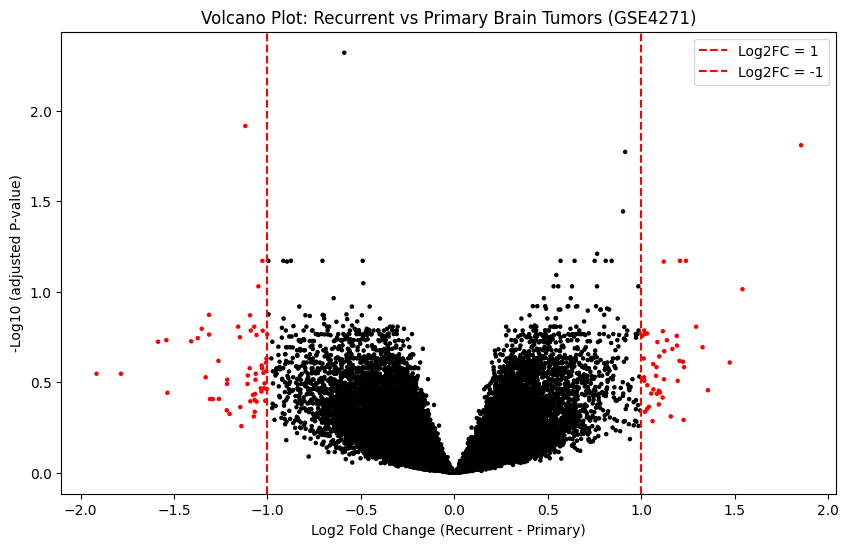

In [9]:
# Plot volcano plot

colors = np.where(abs(volcano_df["log2FC"]) >= 1, "red", "black")

plt.figure(figsize=(10, 6))
plt.scatter(volcano_df['log2FC'], volcano_df['adj -log10 p-value'], alpha=1, c=colors,s=5)
plt.title('Volcano Plot: Recurrent vs Primary Brain Tumors (GSE4271)')

plt.xlabel('Log2 Fold Change (Recurrent - Primary)')
plt.ylabel('-Log10 (adjusted P-value)')


plt.axvline(x=1, color='red', linestyle='--', label='Log2FC = 1')
plt.axvline(x=-1, color='red', linestyle='--', label='Log2FC = -1')
plt.legend()




C:\Users\bbh373\AppData\Local\Temp\ipykernel_1836\2009433189.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sigs['abs_fc'] = sigs['log2FC'].abs()


<Figure size 1000x600 with 0 Axes>

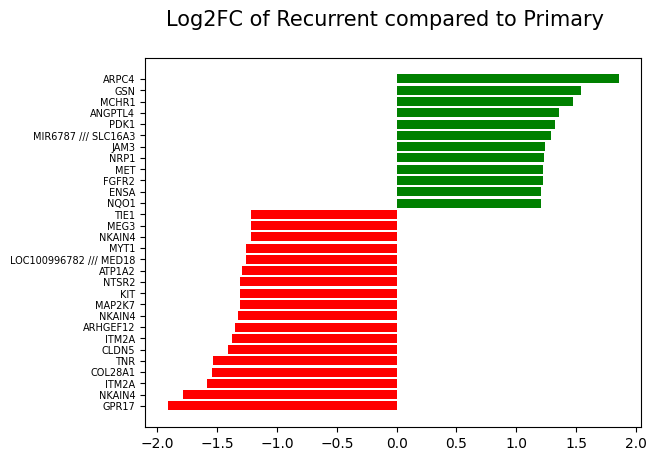

In [10]:
top_n = 30

sigs = volcano_df[abs(volcano_df["log2FC"]) >1]


sigs['abs_fc'] = sigs['log2FC'].abs()
sigs = sigs.sort_values('abs_fc', ascending=False).head(top_n)
sigs = sigs.sort_values('log2FC')

# Plot horizontal bar plot
vals = sigs["log2FC"]
colors = np.where(vals>1,"green","red")

plt.figure(figsize=(10, 6))
fig, ax = plt.subplots()
fig.suptitle('Log2FC of Recurrent compared to Primary', fontsize=15)

y_pos = np.arange(len(sigs))
ax.barh(y_pos,vals,align="center",color = colors)
ax.set_yticks(y_pos)
ax.set_yticklabels(vals.index,fontsize=7)

x_min = np.floor(vals.min())


plt.show()





In [11]:
#Create general info file

print(sigs)

df1 = pd.DataFrame({'Data': ['a', 'b', 'c', 'd']})    
df2 = pd.DataFrame({'Data': [1, 2, 3, 4]})  
df3 = pd.DataFrame({'Data': [1.1, 1.2, 1.3, 1.4]})

with pd.ExcelWriter('data/multiple.xlsx') as writer:
    df1.to_excel(writer, sheet_name='Sheeta')
    df2.to_excel(writer, sheet_name='Sheetb')
    df3.to_excel(writer, sheet_name='Sheetc')


                          log2FC   p-value  primary_mean  recurrent_mean  \
Gene Symbol                                                                
GPR17                  -1.914609  0.008676      6.744008        4.829399   
NKAIN4                 -1.783981  0.008701      8.769030        6.985049   
ITM2A                  -1.585035  0.001610      9.955380        8.370344   
COL28A1                -1.541072  0.001367      8.234408        6.693336   
TNR                    -1.535533  0.021413      9.878660        8.343128   
CLDN5                  -1.407792  0.001554      9.208244        7.800452   
ITM2A                  -1.372985  0.001189     10.229315        8.856329   
ARHGEF12               -1.351643  0.000458      4.727802        3.376159   
NKAIN4                 -1.330560  0.010316      8.865187        7.534627   
MAP2K7                 -1.312732  0.000197      5.830448        4.517716   
KIT                    -1.312435  0.000906      8.071139        6.758704   
NTSR2       

ModuleNotFoundError: No module named 'openpyxl'

### "Nearly all WHO grade III tumor specimens examined (65/73 or 89%) were classified as PN regardless of whether they exhibited oligodendroglial or astrocytic morphology. In contrast, a significant proportion of WHO grade IV lesions (GBM) were classified into each of the three molecular categories. Of 183 GBM samples examined, 31% were PN, 20% were Prolif, and 49% were Mes"

In [ ]:
gene = "TP53"

# preferred: return a DataFrame (even if single row)
if gene in primary_expression.index:
    rows1 = primary_expression.loc[[gene]]      # always a DataFrame
    rows2 = recurrent_expression.loc[[gene]]

else:
    print("None")
    
avg_per_column = rows1.mean(axis=0, skipna=True)   # returns a Series indexed by sample/column name
primary_EGFR_expression = avg_per_column.mean()

avg_per_column = rows2.mean(axis=0, skipna=True)   # returns a Series indexed by sample/column name
recurrent_EGFR_expression = avg_per_column.mean()


print(primary_EGFR_expression - recurrent_EGFR_expression)





-0.40305794710073695
